
# ASR Inference with CTC Decoder

This tutorial shows how to perform speech recognition inference using a
CTC beam search decoder with lexicon constraint and KenLM language model
support. We demonstrate this on a pretrained wav2vec 2.0 model trained
using CTC loss.


## Overview

Beam search decoding works by iteratively expanding text hypotheses (beams)
with next possible characters, and maintaining only the hypotheses with the
highest scores at each time step. A language model can be incorporated into
the scoring computation, and adding a lexicon constraint restricts the
next possible tokens for the hypotheses so that only words from the lexicon
can be generated.

The underlying implementation is ported from [Flashlight](https://arxiv.org/pdf/2201.12465.pdf)_'s
beam search decoder. A mathematical formula for the decoder optimization can be
found in the [Wav2Letter paper](https://arxiv.org/pdf/1609.03193.pdf)_, and
a more detailed algorithm can be found in this [blog](https://towardsdatascience.com/boosting-your-sequence-generation-performance-with-beam-search-language-model-decoding-74ee64de435a)_.

Running ASR inference using a CTC Beam Search decoder with a language
model and lexicon constraint requires the following components

-  Acoustic Model: model predicting phonetics from audio waveforms
-  Tokens: the possible predicted tokens from the acoustic model
-  Lexicon: mapping between possible words and their corresponding
   tokens sequence
-  Language Model (LM): n-gram language model trained with the [KenLM
   library](https://kheafield.com/code/kenlm/)_, or custom language
   model that inherits :py:class:`~torchaudio.models.decoder.CTCDecoderLM`




## Acoustic Model and Set Up

First we import the necessary utilities and fetch the data that we are
working with




In [ ]:
!pip install torchaudio==2.1.0


In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.1.0+cu121
2.1.0+cu121


In [ ]:
!pip install flashlight-text
!pip install git+https://github.com/kpu/kenlm.git

In [ ]:
import time
from typing import List

import IPython
import matplotlib.pyplot as plt
from torchaudio.models.decoder import ctc_decoder
from torchaudio.utils import download_asset

We use the pretrained [Wav2Vec 2.0](https://arxiv.org/abs/2006.11477)_
Base model that is finetuned on 10 min of the [LibriSpeech
dataset](http://www.openslr.org/12)_, which can be loaded in using
:data:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_10M`.
For more detail on running Wav2Vec 2.0 speech
recognition pipelines in torchaudio, please refer to [this
tutorial](./speech_recognition_pipeline_tutorial.html)_.




In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_10M
acoustic_model = bundle.get_model()

We will load a sample from the LibriSpeech test-other dataset.




In [ ]:
speech_file = download_asset("tutorial-assets/ctc-decoding/1688-142285-0007.wav")

IPython.display.Audio(speech_file)

The transcript corresponding to this audio file is

```
i really was very much afraid of showing him how much shocked i was at some parts of what he said
```


In [ ]:
waveform, sample_rate = torchaudio.load(speech_file)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

## Files and Data for Decoder

Next, we load in our token, lexicon, and language model data, which are used
by the decoder to predict words from the acoustic model output. Pretrained
files for the LibriSpeech dataset can be downloaded through torchaudio,
or the user can provide their own files.




### Tokens

The tokens are the possible symbols that the acoustic model can predict,
including the blank and silent symbols. It can either be passed in as a
file, where each line consists of the tokens corresponding to the same
index, or as a list of tokens, each mapping to a unique index.

```
# tokens.txt
_
|
e
t
...
```


In [ ]:
tokens = [label.lower() for label in bundle.get_labels()]
print(tokens)

### Lexicon

The lexicon is a mapping from words to their corresponding tokens
sequence, and is used to restrict the search space of the decoder to
only words from the lexicon. The expected format of the lexicon file is
a line per word, with a word followed by its space-split tokens.

```
# lexcion.txt
a a |
able a b l e |
about a b o u t |
...
...
```


### Language Model

A language model can be used in decoding to improve the results, by
factoring in a language model score that represents the likelihood of
the sequence into the beam search computation. Below, we outline the
different forms of language models that are supported for decoding.




#### No Language Model

To create a decoder instance without a language model, set `lm=None`
when initializing the decoder.




#### KenLM

This is an n-gram language model trained with the [KenLM
library](https://kheafield.com/code/kenlm/)_. Both the ``.arpa`` or
the binarized ``.bin`` LM can be used, but the binary format is
recommended for faster loading.

The language model used in this tutorial is a 4-gram KenLM trained using
[LibriSpeech](http://www.openslr.org/11)_.




#### Custom Language Model

Users can define their own custom language model in Python, whether
it be a statistical or neural network language model, using
:py:class:`~torchaudio.models.decoder.CTCDecoderLM` and
:py:class:`~torchaudio.models.decoder.CTCDecoderLMState`.

For instance, the following code creates a basic wrapper around a PyTorch
``torch.nn.Module`` language model.




In [ ]:
from torchaudio.models.decoder import CTCDecoderLM, CTCDecoderLMState


class CustomLM(CTCDecoderLM):
    """Create a Python wrapper around `language_model` to feed to the decoder."""

    def __init__(self, language_model: torch.nn.Module):
        CTCDecoderLM.__init__(self)
        self.language_model = language_model
        self.sil = -1  # index for silent token in the language model
        self.states = {}

        language_model.eval()

    def start(self, start_with_nothing: bool = False):
        state = CTCDecoderLMState()
        with torch.no_grad():
            score = self.language_model(self.sil)

        self.states[state] = score
        return state

    def score(self, state: CTCDecoderLMState, token_index: int):
        outstate = state.child(token_index)
        if outstate not in self.states:
            score = self.language_model(token_index)
            self.states[outstate] = score
        score = self.states[outstate]

        return outstate, score

    def finish(self, state: CTCDecoderLMState):
        return self.score(state, self.sil)

#### Downloading Pretrained Files

Pretrained files for the LibriSpeech dataset can be downloaded using
:py:func:`~torchaudio.models.decoder.download_pretrained_files`.

Note: this cell may take a couple of minutes to run, as the language
model can be large




In [ ]:
from torchaudio.models.decoder import download_pretrained_files

files = download_pretrained_files("librispeech-4-gram")

print(files)

## Construct Decoders
In this tutorial, we construct both a beam search decoder and a greedy decoder
for comparison.




### Beam Search Decoder
The decoder can be constructed using the factory function
:py:func:`~torchaudio.models.decoder.ctc_decoder`.
In addition to the previously mentioned components, it also takes in various beam
search decoding parameters and token/word parameters.

This decoder can also be run without a language model by passing in `None` into the
`lm` parameter.




In [ ]:
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

# from torchaudio.models.decoder import CTCDecoder

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=files.tokens,
    lm=files.lm,
    nbest=3,
    beam_size=1500,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

### Greedy Decoder




In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> List[str]:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        joined = "".join([self.labels[i] for i in indices])
        return joined.replace("|", " ").strip().split()


greedy_decoder = GreedyCTCDecoder(tokens)

## Run Inference

Now that we have the data, acoustic model, and decoder, we can perform
inference. The output of the beam search decoder is of type
:py:class:`~torchaudio.models.decoder.CTCHypothesis`, consisting of the
predicted token IDs, corresponding words (if a lexicon is provided), hypothesis score,
and timesteps corresponding to the token IDs. Recall the transcript corresponding to the
waveform is

```
i really was very much afraid of showing him how much shocked i was at some parts of what he said
```


In [ ]:
actual_transcript = "i really was very much afraid of showing him how much shocked i was at some parts of what he said"
actual_transcript = actual_transcript.split()

emission, _ = acoustic_model(waveform)

The greedy decoder gives the following result.




In [ ]:
greedy_result = greedy_decoder(emission[0])
greedy_transcript = " ".join(greedy_result)
greedy_wer = torchaudio.functional.edit_distance(actual_transcript, greedy_result) / len(actual_transcript)

print(f"Transcript: {greedy_transcript}")
print(f"WER: {greedy_wer}")

Transcript: i reily was very much affrayd of showing him howmuch shoktd i wause at some parte of what he seid
WER: 0.38095238095238093


Using the beam search decoder:




In [ ]:
beam_search_result = beam_search_decoder(emission)
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(
    actual_transcript
)

print(f"Transcript: {beam_search_transcript}")
print(f"WER: {beam_search_wer}")

Transcript: i really was very much afraid of showing him how much shocked i was at some part of what he said
WER: 0.047619047619047616


<div class="alert alert-info"><h4>Note</h4><p>The :py:attr:`~torchaudio.models.decoder.CTCHypothesis.words`
   field of the output hypotheses will be empty if no lexicon
   is provided to the decoder. To retrieve a transcript with lexicon-free
   decoding, you can perform the following to retrieve the token indices,
   convert them to original tokens, then join them together.

   .. code::

      tokens_str = "".join(beam_search_decoder.idxs_to_tokens(beam_search_result[0][0].tokens))
      transcript = " ".join(tokens_str.split("|"))</p></div>

We see that the transcript with the lexicon-constrained beam search
decoder produces a more accurate result consisting of real words, while
the greedy decoder can predict incorrectly spelled words like “affrayd”
and “shoktd”.




### Incremental decoding

If the input speech is long, one can decode the emission in
incremental manner.

You need to first initialize the internal state of the decoder with
:py:meth:`~torchaudio.models.decoder.CTCDecoder.decode_begin`.



In [ ]:
beam_search_decoder.decode_begin()

Then, you can pass emissions to
:py:meth:`~torchaudio.models.decoder.CTCDecoder.decode_begin`.
Here we use the same emission but pass it to the decoder one frame
at a time.



In [ ]:
for t in range(emission.size(1)):
    beam_search_decoder.decode_step(emission[0, t:t + 1, :])

Finally, finalize the internal state of the decoder, and retrieve the
result.



In [ ]:
beam_search_decoder.decode_end()
beam_search_result_inc = beam_search_decoder.get_final_hypothesis()

The result of incremental decoding is identical to batch decoding.




In [ ]:
beam_search_transcript_inc = " ".join(beam_search_result_inc[0].words).strip()
beam_search_wer_inc = torchaudio.functional.edit_distance(
    actual_transcript, beam_search_result_inc[0].words) / len(actual_transcript)

print(f"Transcript: {beam_search_transcript_inc}")
print(f"WER: {beam_search_wer_inc}")

assert beam_search_result[0][0].words == beam_search_result_inc[0].words
assert beam_search_result[0][0].score == beam_search_result_inc[0].score
torch.testing.assert_close(beam_search_result[0][0].timesteps, beam_search_result_inc[0].timesteps)

Transcript: i really was very much afraid of showing him how much shocked i was at some part of what he said
WER: 0.047619047619047616


## Timestep Alignments
Recall that one of the components of the resulting Hypotheses is timesteps
corresponding to the token IDs.




In [ ]:
timesteps = beam_search_result[0][0].timesteps
predicted_tokens = beam_search_decoder.idxs_to_tokens(beam_search_result[0][0].tokens)

print(predicted_tokens, len(predicted_tokens))
print(timesteps, timesteps.shape[0])

Below, we visualize the token timestep alignments relative to the original waveform.




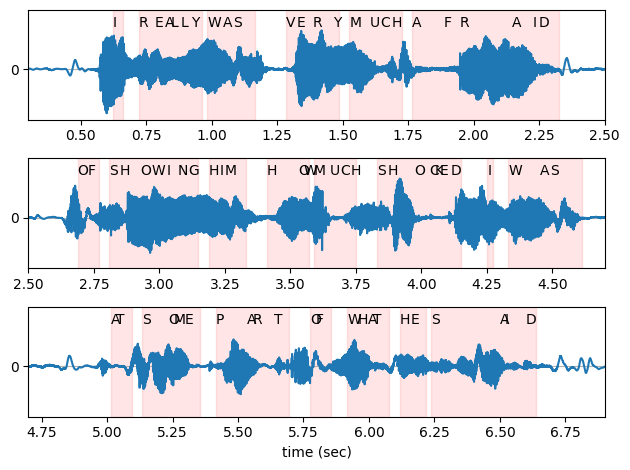

In [ ]:
def plot_alignments(waveform, emission, tokens, timesteps, sample_rate):

    t = torch.arange(waveform.size(0)) / sample_rate
    ratio = waveform.size(0) / emission.size(1) / sample_rate

    chars = []
    words = []
    word_start = None
    for token, timestep in zip(tokens, timesteps * ratio):
        if token == "|":
            if word_start is not None:
                words.append((word_start, timestep))
            word_start = None
        else:
            chars.append((token, timestep))
            if word_start is None:
                word_start = timestep

    fig, axes = plt.subplots(3, 1)

    def _plot(ax, xlim):
        ax.plot(t, waveform)
        for token, timestep in chars:
            ax.annotate(token.upper(), (timestep, 0.5))
        for word_start, word_end in words:
            ax.axvspan(word_start, word_end, alpha=0.1, color="red")
        ax.set_ylim(-0.6, 0.7)
        ax.set_yticks([0])
        ax.grid(True, axis="y")
        ax.set_xlim(xlim)

    _plot(axes[0], (0.3, 2.5))
    _plot(axes[1], (2.5, 4.7))
    _plot(axes[2], (4.7, 6.9))
    axes[2].set_xlabel("time (sec)")
    fig.tight_layout()


plot_alignments(waveform[0], emission, predicted_tokens, timesteps, bundle.sample_rate)

## Beam Search Decoder Parameters

In this section, we go a little bit more in depth about some different
parameters and tradeoffs. For the full list of customizable parameters,
please refer to the
:py:func:`documentation <torchaudio.models.decoder.ctc_decoder>`.




### Helper Function




In [ ]:
def print_decoded(decoder, emission, param, param_value):
    start_time = time.monotonic()
    result = decoder(emission)
    decode_time = time.monotonic() - start_time

    transcript = " ".join(result[0][0].words).lower().strip()
    score = result[0][0].score
    print(f"{param} {param_value:<3}: {transcript} (score: {score:.2f}; {decode_time:.4f} secs)")

### nbest

This parameter indicates the number of best hypotheses to return, which
is a property that is not possible with the greedy decoder. For
instance, by setting ``nbest=3`` when constructing the beam search
decoder earlier, we can now access the hypotheses with the top 3 scores.




In [ ]:
for i in range(3):
    transcript = " ".join(beam_search_result[0][i].words).strip()
    score = beam_search_result[0][i].score
    print(f"{transcript} (score: {score})")

### beam size

The ``beam_size`` parameter determines the maximum number of best
hypotheses to hold after each decoding step. Using larger beam sizes
allows for exploring a larger range of possible hypotheses which can
produce hypotheses with higher scores, but it is computationally more
expensive and does not provide additional gains beyond a certain point.

In the example below, we see improvement in decoding quality as we
increase beam size from 1 to 5 to 50, but notice how using a beam size
of 500 provides the same output as beam size 50 while increase the
computation time.




In [ ]:
beam_sizes = [1, 5, 50, 500]

for beam_size in beam_sizes:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=files.tokens,
        lm=files.lm,
        beam_size=beam_size,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, emission, "beam size", beam_size)

### beam size token

The ``beam_size_token`` parameter corresponds to the number of tokens to
consider for expanding each hypothesis at the decoding step. Exploring a
larger number of next possible tokens increases the range of potential
hypotheses at the cost of computation.




In [ ]:
num_tokens = len(tokens)
beam_size_tokens = [1, 5, 10, num_tokens]

for beam_size_token in beam_size_tokens:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=files.tokens,
        lm=files.lm,
        beam_size_token=beam_size_token,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, emission, "beam size token", beam_size_token)

### beam threshold

The ``beam_threshold`` parameter is used to prune the stored hypotheses
set at each decoding step, removing hypotheses whose scores are greater
than ``beam_threshold`` away from the highest scoring hypothesis. There
is a balance between choosing smaller thresholds to prune more
hypotheses and reduce the search space, and choosing a large enough
threshold such that plausible hypotheses are not pruned.




In [ ]:
beam_thresholds = [1, 5, 10, 25]

for beam_threshold in beam_thresholds:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=files.tokens,
        lm=files.lm,
        beam_threshold=beam_threshold,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, emission, "beam threshold", beam_threshold)

### language model weight

The ``lm_weight`` parameter is the weight to assign to the language
model score which to accumulate with the acoustic model score for
determining the overall scores. Larger weights encourage the model to
predict next words based on the language model, while smaller weights
give more weight to the acoustic model score instead.




In [ ]:
lm_weights = [0, LM_WEIGHT, 15]

for lm_weight in lm_weights:
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=files.tokens,
        lm=files.lm,
        lm_weight=lm_weight,
        word_score=WORD_SCORE,
    )

    print_decoded(beam_search_decoder, emission, "lm weight", lm_weight)

### additional parameters

Additional parameters that can be optimized include the following

- ``word_score``: score to add when word finishes
- ``unk_score``: unknown word appearance score to add
- ``sil_score``: silence appearance score to add
- ``log_add``: whether to use log add for lexicon Trie smearing


